# Goddard problem - Hamiltonian point of view

## Preliminaries

In [1]:
using ForwardDiff, DifferentialEquations, Plots, LinearAlgebra, MINPACK

In [2]:
# Alias for gradient and jacobian
grad(f, x) = ForwardDiff.gradient(f, x)
jac(f, x)  = ForwardDiff.jacobian(f, x);

## Brackets

In [3]:
function Lie(X, f)
    
    function Xf(x)
        df = grad(f, x)
        return df'*X(x)
    end
    
    return Xf

end
    
#function Lie(X, Y)
#
#    function XY(x)
#        dX = jac(X, x)
#        dY = jac(Y, x)
#        return dY*X(x)-dX*Y(x)
#    end
#
#    return XY
#
#end

function Poisson(f, g)

    function fg(x, p)
        n = size(x, 1)
        ff = z -> f(z[1:n], z[n+1:2n])
        gg = z -> g(z[1:n], z[n+1:2n])
        df = grad(ff, [ x ; p ])
        dg = grad(gg, [ x ; p ])
        return df[n+1:2n]'*dg[1:n] - df[1:n]'*dg[n+1:2n]
    end

    return fg

end;

## OCP

In [4]:
struct Mayer 
    f₀::Function 
    f₁::Function
    control_bounds::Tuple{Number, Number}
    constraint::Union{Function, Nothing}
end
@enum CONTROL min=1 max=2 singular=3 boundary=4

## Hamiltonians

In [5]:
struct Hamiltonian f::Function end

function (h::Hamiltonian)(x, p) # https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects
   return h.f(x,p)
end

function __vector_fields(ocp::Mayer)
    f₀ = ocp.f₀
    f₁ = ocp.f₁
    return f₀, f₁
end

function __hamiltonian_lifts(ocp::Mayer)
    f₀ = ocp.f₀
    f₁ = ocp.f₁
    h₀(x, p) = p'*f₀(x)
    h₁(x, p) = p'*f₁(x)   
    return h₀, h₁
end

function __min_control(ocp::Mayer)
     u(x, p) = ocp.control_bounds[1]
end

function __max_control(ocp::Mayer)
     u(x, p) = ocp.control_bounds[2]
end

function __singular_control(ocp::Mayer)
    
    h₀, h₁ = __hamiltonian_lifts(ocp)
    H₀₁  = Poisson(h₀, h₁)
    H₀₀₁ = Poisson(h₀, H₀₁)
    H₁₀₁ = Poisson(h₁, H₀₁)
    us(x, p) = -H₀₀₁(x, p)/H₁₀₁(x, p)  
    
    return us
    
end

function __boundary_control(ocp::Mayer)
    
    f₀, f₁ = __vector_fields(ocp)
    g = ocp.constraint
    ub(x) = -Lie(f₀, g)(x) / Lie(f₁, g)(x)
    
    return ub
    
end

function __boundary_multiplier(ocp::Mayer)
   
    f₀ = ocp.f₀
    f₁ = ocp.f₁  
    h₀, h₁ = __hamiltonian_lifts(ocp)
    H₀₁ = Poisson(h₀, h₁)   
    g = ocp.constraint
    μb(x, p) = H₀₁(x, p) / Lie(f₁, g)(x)
    
    return μb
    
end

#function __gradient_constrain(ocp::Mayer)  
#    g = ocp.constraint
#    ∇g(x) = grad(g, x)
#    return ∇g
#end

function __hamiltonian_min(ocp::Mayer)
    h₀, h₁ = __hamiltonian_lifts(ocp)
    u = __min_control(ocp)
    h(x, p) = h₀(x, p) + u(x, p) * h₁(x, p)
    return h
end

function __hamiltonian_max(ocp::Mayer)
    h₀, h₁ = __hamiltonian_lifts(ocp)
    u = __max_control(ocp)
    h(x, p) = h₀(x, p) + u(x, p) * h₁(x, p)
    return h
end

function __hamiltonian_sing(ocp::Mayer)
    h₀, h₁ = __hamiltonian_lifts(ocp)
    us = __singular_control(ocp)
    h(x, p) = h₀(x, p) + us(x, p) * h₁(x, p)
    return h
end

function __hamiltonian_bound(ocp::Mayer)
    h₀, h₁ = __hamiltonian_lifts(ocp)
    ub = __boundary_control(ocp)
    μb = __boundary_multiplier(ocp)  
    g = ocp.constraint
    h(x, p) = h₀(x, p) + ub(x) * h₁(x, p) + μb(x,p)*g(x)
    return h
end

function Hamiltonian(ocp::Mayer, control::CONTROL)
    if control==singular
        return Hamiltonian(__hamiltonian_sing(ocp))
    elseif control==min
        return Hamiltonian(__hamiltonian_min(ocp))
    elseif control==max
        return Hamiltonian(__hamiltonian_max(ocp))
    elseif control==boundary
        return Hamiltonian(__hamiltonian_bound(ocp))
    else
        nothing
    end    
end;

function Control(ocp::Mayer, control::CONTROL)
    if control==singular
        return __singular_control(ocp)
    elseif control==min
        return __min_control(ocp)
    elseif control==max
        return __max_control(ocp)
    elseif control==boundary
        return __boundary_control(ocp)
    else
        nothing
    end    
end;

function Multiplier(ocp::Mayer)
   return __boundary_multiplier(ocp)
end;

## Flow

In [15]:
function __abstol()
    return 1e-8
end

function __reltol()
    return 1e-8
end

function __saveat()
    return []
end

# Flow from a Hamiltonian
function Flow(H::Hamiltonian)

    h = H.f
    
    function rhs!(dz, z, dummy, t)
        n = size(z, 1)÷2
        foo = z -> h(z[1:n], z[n+1:2*n])
        dh = grad(foo, z)
        dz[1:n] = dh[n+1:2n]
        dz[n+1:2n] = -dh[1:n]
    end
    
    function f(tspan, x0, p0; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        z0 = [ x0 ; p0 ]
        ode = ODEProblem(rhs!, z0, tspan)
        sol = OrdinaryDiffEq.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, p0, tf; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        sol = f((t0, tf), x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end], sol[n+1:2*n, end]
    end
    
    return f

end;

## Problem

In [16]:
# Parameters
Cd = 310.0
Tmax = 3.5
β = 500.0
b = 2.0
t0 = 0.0
r0 = 1.0
v0 = 0.0
vmax = 0.1
m0 = 1.0
x0 = [ r0, v0, m0 ]
mf = 0.6;
n = length(x0)

# Dynamics
function F0(x)
    r, v, m = x
    D = Cd * v^2 * exp(-β*(r-1.0))
    F = [ v, -D/m-1.0/r^2, 0.0 ]
    return F
end

function F1(x)
    r, v, m = x
    F = [ 0.0, Tmax/m, -b*Tmax ]
    return F
end

# State constraint
g(x) = vmax-x[2] # vmax - v ≥ 0

# OCP
ocp = Mayer(F0, F1, (0.0, 1.0), g)

# Hamiltonians
H0 = Hamiltonian(ocp, min)
Hr = Hamiltonian(ocp, max) 
Hs = Hamiltonian(ocp, singular)
Hb = Hamiltonian(ocp, boundary)

# Flows
f0 = Flow(H0);
fr = Flow(Hr);
fs = Flow(Hs);
fb = Flow(Hb);

# Controls
u0 = Control(ocp, min)
ur = Control(ocp, max)
us = Control(ocp, singular)
ub = Control(ocp, boundary)
μb = Multiplier(ocp)

# Hamiltonian lifts for the shooting method
H1(x, p) = p'*F1(x)
H01 = Poisson(H0, H1);

## Indirect

In [17]:
# Shooting function
function shoot(p0, t1, t2, t3, tf) # B+ S C B0 structure

    x1, p1 = fr(t0, x0, p0, t1)
    x2, p2 = fs(t1, x1, p1, t2)
    x3, p3 = fb(t2, x2, p2, t3)
    xf, pf = f0(t3, x3, p3, tf)
    s = zeros(eltype(p0), 7)
    s[1:2] = pf[1:2] - [ 1.0, 0.0 ]
    s[3] = xf[3] - mf # supposed to be active
    s[4] = H1(x1, p1)
    s[5] = H01(x1, p1)
    s[6] = g(x2)
    s[7] = H0(xf, pf) # free tf

    return s

end;

In [18]:
ξ = [3.94288, 0.146288, 0.0541244, 0.02524675, 0.06160209, 0.1040166, 0.202983945]; # to change and use direct solution

In [20]:
# Solve
foo(ξ) = shoot(ξ[1:3], ξ[4], ξ[5], ξ[6], ξ[7])
jfoo(ξ) = ForwardDiff.jacobian(foo, ξ)
foo!(s, ξ) = ( s[:] = foo(ξ); nothing )
jfoo!(js, ξ) = ( js[:] = jfoo(ξ); nothing )

println("Initial value of shooting:\n", foo(ξ), "\n\n")

nl_sol = fsolve(foo!, jfoo!, ξ, show_trace=true); println(nl_sol)
#nl_sol = fsolve(foo!, ξ, show_trace=true); println(nl_sol);

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:3]
    t1 = nl_sol.x[4]
    t2 = nl_sol.x[5]
    t3 = nl_sol.x[6]
    tf = nl_sol.x[7];
else
    error("Not converged")
end

Initial value of shooting:
[-0.05699658653208994, 0.001862202458612777, -0.02456199498974987, -0.0270151163166652, -0.21567976587082738, -0.01211545970237711, 0.015715031545160595]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     2.156798e-01     0.000000e+00         0.062942
     2     1.572155e-01     1.782618e-03         0.522183
     3     6.273827e-02     4.416655e-04         0.054640
     4     3.028226e-04     2.824758e-04         0.021213
     5     1.680628e-03     7.268045e-07         0.040508
     6     1.008621e-04     2.774963e-08         0.036555
     7     2.557135e-05     1.768405e-09         0.029711
     8     8.225907e-07     1.318199e-10         0.114748
     9     1.836724e-06     3.440597e-11         0.045751
    10     1.894817e-07     7.179267e-13         0.045283
    11     2.223689e-08     2.542796e-15         0.019764
    12     1.182109e-10     4.904201e-17         0.049036
Results of

0.2020474405238758

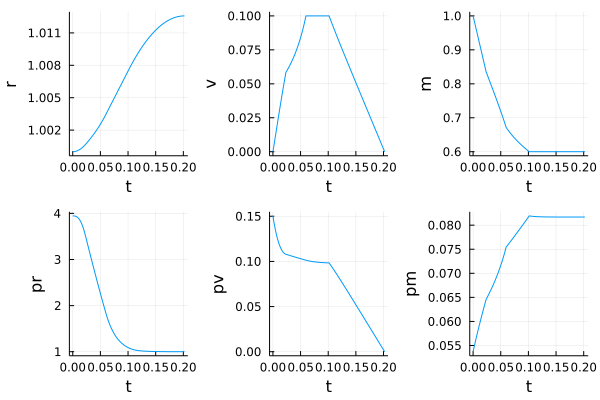

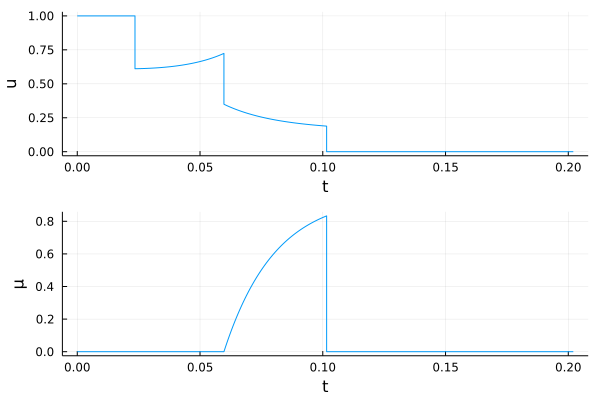

In [11]:
# Plots
ode_sol = fr((t0, t1), x0, p0)
tt0 = ode_sol.t
xx0 = [ ode_sol[1:n, j] for j in 1:size(tt0, 1) ]
pp0 = [ ode_sol[n+1:2n, j] for j in 1:size(tt0, 1) ]
uu0 = ur.(xx0, pp0)
μ0  = zeros(size(tt0, 1))

ode_sol = fs((t1, t2), xx0[end], pp0[end])
tt1 = ode_sol.t
xx1 = [ ode_sol[1:n, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[n+1:2n, j] for j in 1:size(tt1, 1) ]
uu1 = us.(xx1, pp1)
μ1  = zeros(size(tt1, 1))

ode_sol = fb((t2, t3), xx1[end], pp1[end])
tt2 = ode_sol.t
xx2 = [ ode_sol[1:n, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[n+1:2n, j] for j in 1:size(tt2, 1) ]
uu2 = ub.(xx2)
μ2  = μb.(xx2, pp2)

ode_sol = f0((t3, tf), xx2[end], pp2[end])
tt3 = ode_sol.t
xx3 = [ ode_sol[1:n, j] for j in 1:size(tt3, 1) ]
pp3 = [ ode_sol[n+1:2n, j] for j in 1:size(tt3, 1) ]
uu3 = u0.(xx3, pp3)
μ3  = zeros(size(tt3, 1))

t = [ tt0 ; tt1 ; tt2 ; tt3 ]
x = [ xx0 ; xx1 ; xx2 ; xx3 ]
p = [ pp0 ; pp1 ; pp2 ; pp3 ]
u = [ uu0 ; uu1 ; uu2 ; uu3 ]
μ = [ μ0  ; μ1  ; μ2  ; μ3  ]
N = length(t)

r_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "r", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
m_plot  = plot(t, [ x[i][3] for i=1:N ], xlabel = "t", ylabel = "m", legend = false)
pr_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "pr", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
pm_plot = plot(t, [ p[i][3] for i=1:N ], xlabel = "t", ylabel = "pm", legend = false)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
μ_plot  = plot(t, μ, xlabel = "t", ylabel = "μ", legend = false)
display(plot(r_plot, v_plot, m_plot, pr_plot, pv_plot, pm_plot, layout = (2,3)))
display(plot(u_plot, μ_plot, layout = (2,1)))